# Spline inter and extrapolation

In [1]:
from IPython import get_ipython
if get_ipython():
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import math

import latenta as la
la.logger.setLevel("INFO")

## Circular spline

In [2]:
n_cells = 2000
cell_ids = [str(i) for i in range(n_cells)]
cell_index = pd.Series(cell_ids, name = "cell")

angle_value = pd.Series(np.linspace(2., 4., n_cells) % (2 * math.pi), index = cell_index)
# angle_value = pd.Series(np.linspace(3., 5., n_cells) % (2 * math.pi), index = cell_index)
# angle_value = pd.Series(np.linspace(-1., 1., n_cells) % (2 * math.pi), index = cell_index)
angle = la.Fixed(angle_value, distribution = la.distributions.CircularUniform(), label = "angle", symbol = r"\theta")
angle

angle:  ↦ Fixed [cell (2000)]

### Toy data

In [3]:
n_genes = 100

observation_value = pd.DataFrame(
    np.vstack([
        np.random.normal(1., 0.5, n_cells),
        np.sin(angle_value) + np.random.normal(0., 0.5, n_cells),
        np.where((angle_value > 3), 1, 0) + np.random.normal(0., 0.5, n_cells),
        np.exp(-(angle_value - 4)**2) + np.random.normal(0., 0.2, n_cells),
        (angle_value > 2.5) * 1 + (angle_value > 3) * 1 - (angle_value > 3.5) * 3 + np.random.normal(0., 0.5, n_cells),
    ]).T,
    index = cell_index
)
observation_value.columns = [str(i) for i in range(observation_value.shape[1])]
observation_value.columns.name = "gene"

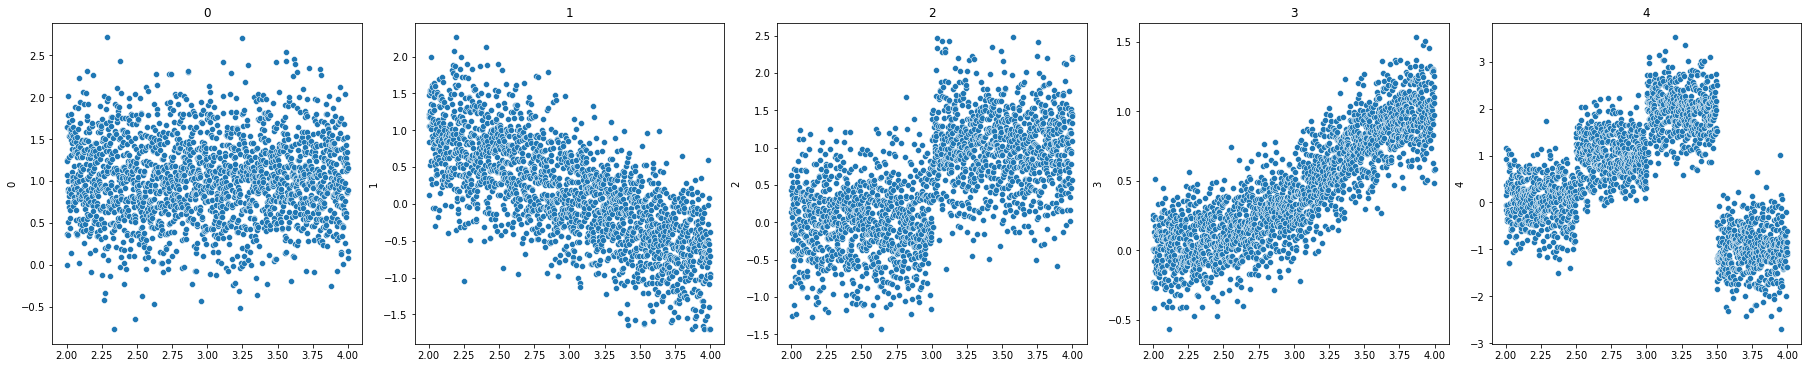

In [4]:
fig, axes = la.plotting.axes_wrap(observation_value.shape[1])
for gene_id, ax in zip(observation_value.columns, axes):
    sns.scatterplot(x = angle_value, y = observation_value[gene_id], ax = ax)
    ax.set_title(gene_id)

### Modelling

In [5]:
x = angle
x = la.Fixed((x.prior_xr() + 4.) % math.tau, distribution = x.distribution)

In [6]:
output_definition = la.Definition.from_xr(observation_value)
output_definition

??: Definition [cell (2000), gene (5)]

In [7]:
models = {}

In [8]:
z = la.links.scalar.CircularSpline(
    x, 
    output = output_definition,
    n_knots = 10,
    basis = la.links.scalar.spline.gaussian,
    step_distribution = la.distributions.Normal(scale = 1.)
)
z.empirical = xr.DataArray(observation_value)
s = la.Parameter(0.5)
dist2 = la.distributions.Normal(loc = z, scale = s)
observation = la.Observation(observation_value, dist2, label = "observation")

models["random_walk"] = la.Model(observation)


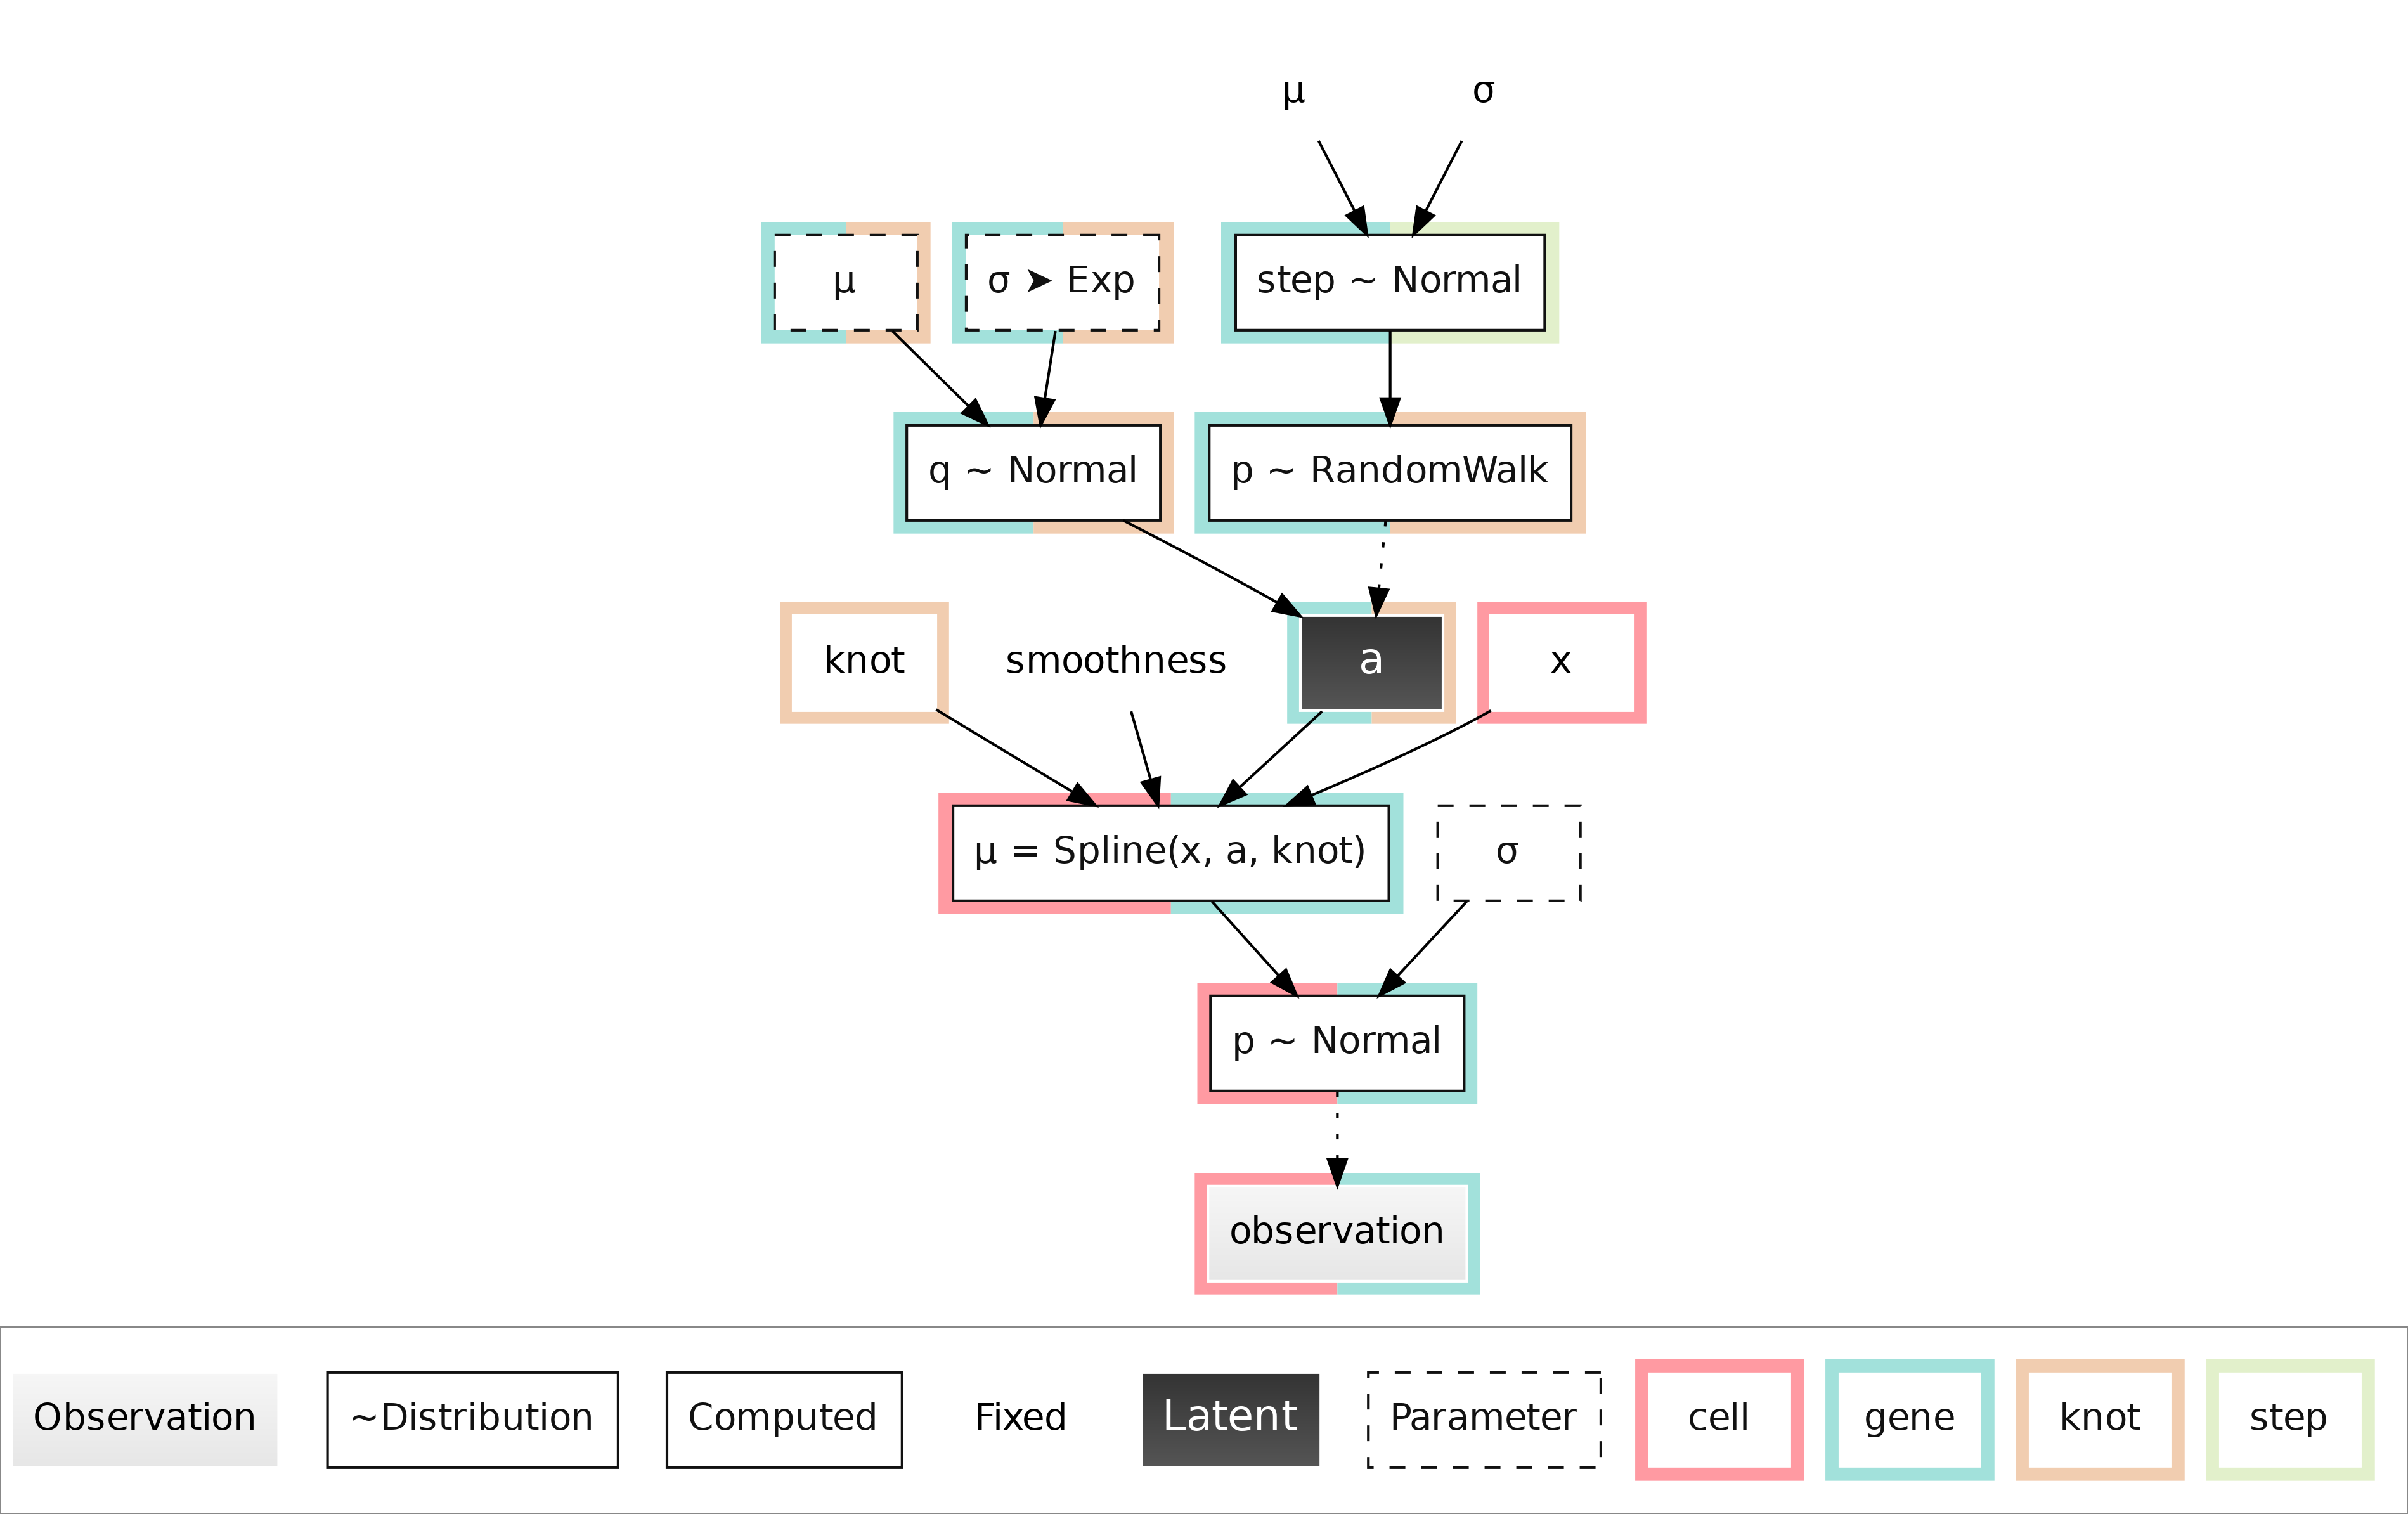

In [9]:
observation.plot()

In [10]:
# retrain = False
retrain = True
for model in models.values():
    if ("trace" not in model) or retrain:
        inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05), 
#                                      subsamplers = {"cell":la.infer.subsampling.Subsampler(150)}
                                    )
        trainer = la.infer.trainer.Trainer(inference)
        trace = trainer.train(10000)
        
        for i in range(4):
            inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01))
            trainer = la.infer.trainer.Trainer(inference)
            model["trace"] = trainer.train(10000)

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [11]:
# retrain = False
for model in models.values():
    if ("observed" not in model) or retrain:
        model["observed"] = la.posterior.Observed(model.observation)
        model["observed"].sample(100)
        
        if "causal" in model:
            del model["causal"]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
for model in models.values():
#     del model["causal"]
    if ("causal" not in model) or retrain:
        causal = la.posterior.scalar.ScalarVectorCausal(x, model.observation)
        causal.observed.sample(1)
        causal.sample(100)
        causal.sample_bootstrap(10)

        model["causal"] = causal

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_3462985/2732017882.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


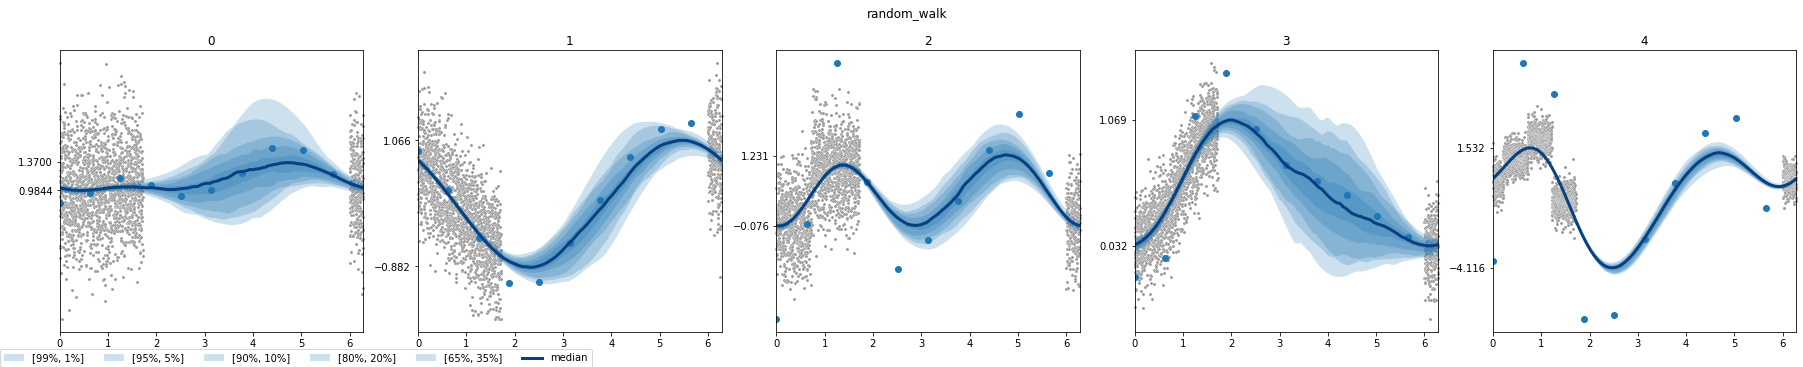

In [13]:
feature_ids = observation_value.columns
for model_id, model in models.items():
    fig = model["causal"].plot_features(feature_ids = feature_ids);
    for feature_id, ax in zip(feature_ids, fig.axes):
        k = model["observed"].samples[model.observation.p.loc.knot].median("sample")
        a = model["observed"].samples[model.observation.p.loc.a].median("sample").sel(gene = feature_id)
        ax.scatter(k, a)

#         baseline = model["observed"].samples[model.observation.p.loc.b].mean("sample").sel(gene = feature_id)
#         ax.axhline(
#             baseline,
#             color = "#333333",
#             dashes = [2]
#         )
#         ax.axhline(
#             0,
#             color = "#333333"
#         )
    fig.suptitle(model_id)

## Regular spline

In [14]:
n_cells = 2000
cell_ids = [str(i) for i in range(n_cells)]
cell_index = pd.Series(cell_ids, name = "cell")

x_value = pd.Series(np.hstack([np.linspace(0., 2., int(n_cells/2)), np.linspace(4., 6., int(n_cells/2))]), index = cell_index)
x = la.Fixed(x_value, distribution = la.distributions.Uniform(0., 8.), label = "x", symbol = r"a")
x

x:  ↦ Fixed [cell (2000)]

### Toy data

In [15]:
observation_value = pd.DataFrame(
    np.vstack([
        np.random.normal(1., 0.5, n_cells),
        x_value * 2 + np.random.normal(0., 0.5, n_cells),
        np.where((x_value > 3), 1, 0) + np.random.normal(0., 0.5, n_cells),
        np.exp(x_value / 6) + np.random.normal(0., 0.2, n_cells),
        ((x_value - 2) **2) + np.random.normal(0., 0.5, n_cells),
        (-(2 * (x_value - 3)) **2) / 20 + np.random.normal(0., 0.5, n_cells),
    ]).T,
    index = cell_index
)
observation_value.columns = [str(i) for i in range(observation_value.shape[1])]
observation_value.columns.name = "gene"

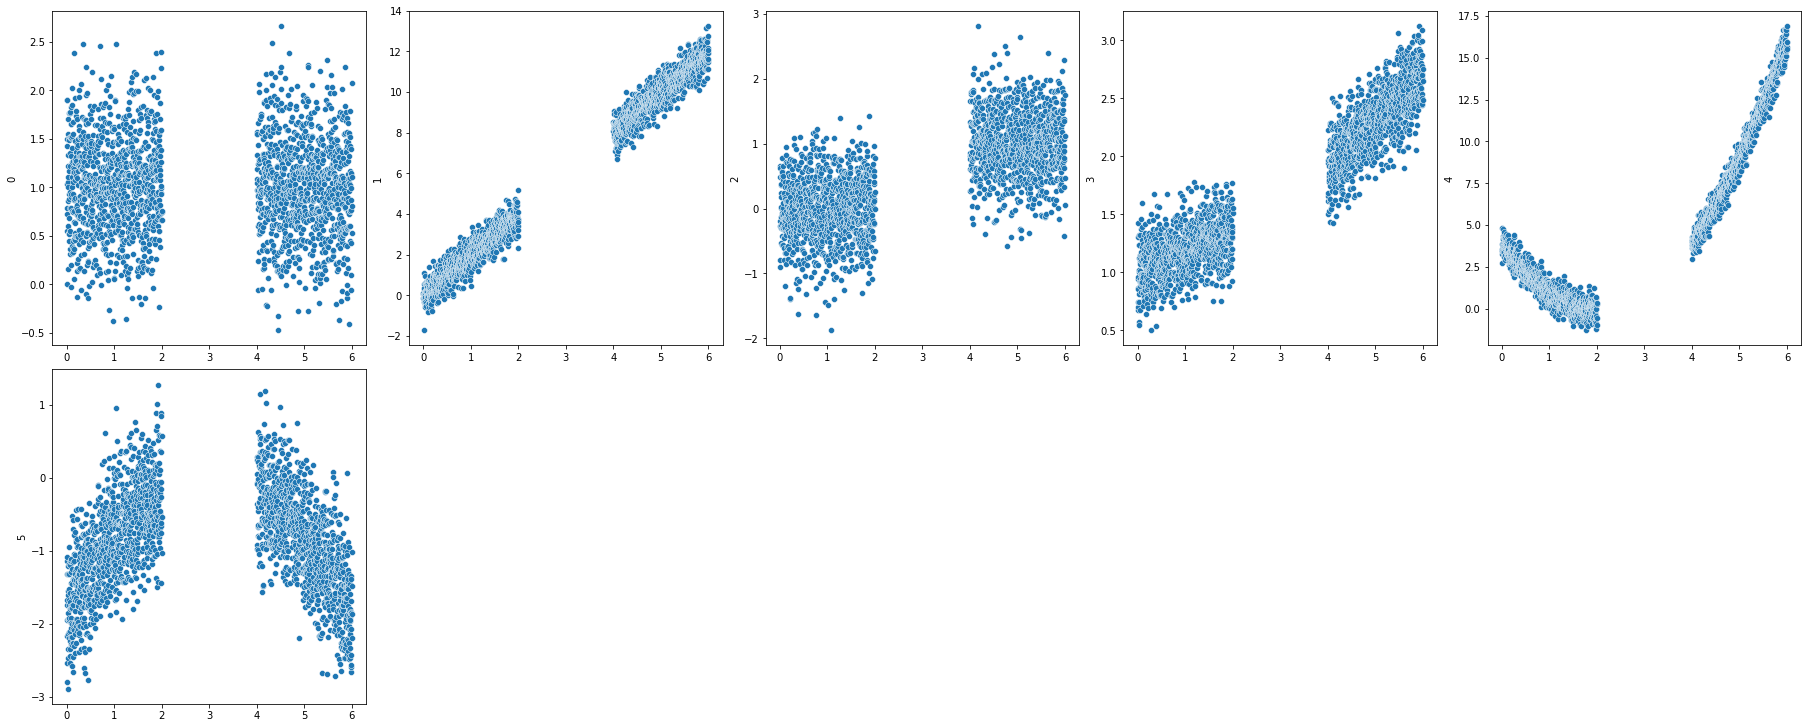

In [16]:
fig, axes = la.plotting.axes_wrap(observation_value.shape[1])
for gene_id, ax in zip(observation_value.columns, axes):
    sns.scatterplot(x = x_value, y = observation_value[gene_id], ax = ax)

### Modelling

In [26]:
output_definition = la.Definition.from_xr(observation_value)
output_definition

??: Definition [cell (2000), gene (6)]

In [27]:
models = {}

In [28]:
# output_distribution = la.distributions.Normal(scale = la.Fixed(observation_value.std() * 2), definition = output_definition[-1:])
z = la.links.scalar.Spline(
    x, 
    output = output_definition,
    n_knots = 20,
    step_distribution = la.distributions.Normal(scale = 1.)
#     output_distribution = output_distribution
)
z.empirical = xr.DataArray(observation_value)
s = la.Parameter(0.5)
dist2 = la.distributions.Normal(loc = z, scale = s)
observation = la.Observation(observation_value, dist2, label = "observation")

models["random_walk"] = la.Model(observation)


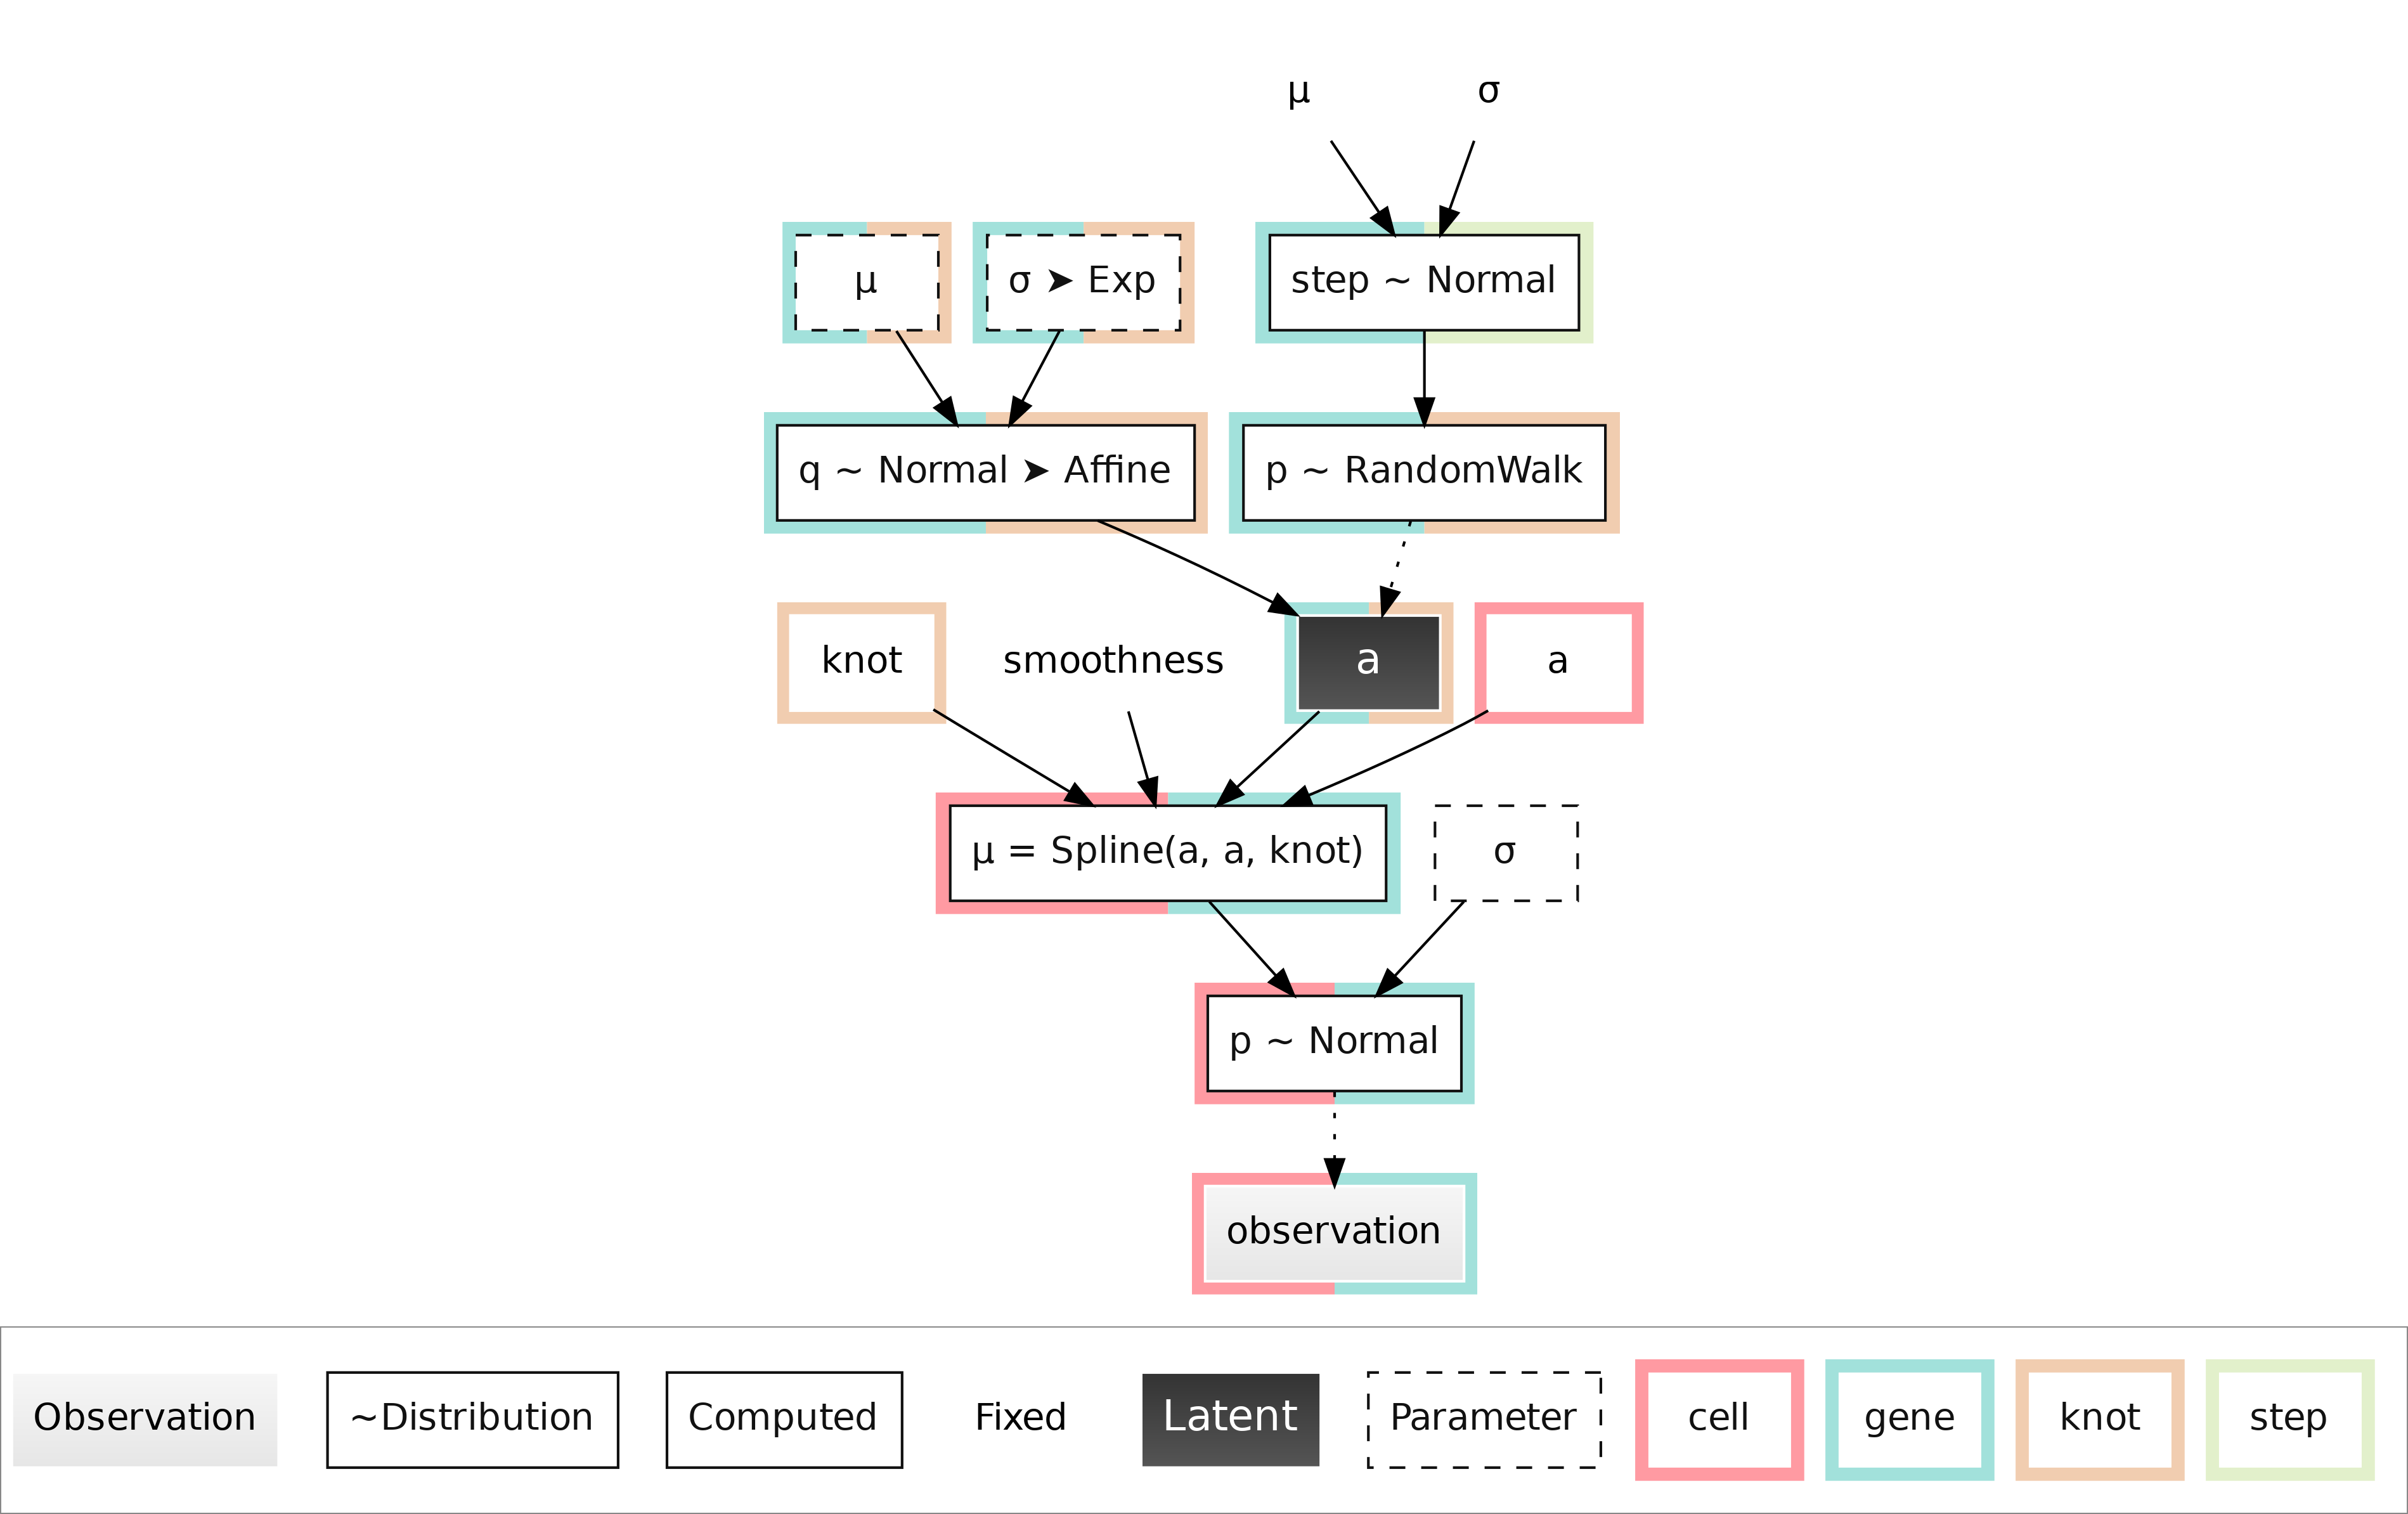

In [29]:
observation.plot()

In [30]:
# retrain = False
retrain = True
for model in models.values():
    if ("trace" not in model) or retrain:
        inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05), 
#                                      subsamplers = {"cell":la.infer.subsampling.Subsampler(150)}
                                    )
        trainer = la.infer.trainer.Trainer(inference)
        trace = trainer.train(10000)
        
        for i in range(5):
            inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01))
            trainer = la.infer.trainer.Trainer(inference)
            model["trace"] = trainer.train(10000)

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [31]:
# retrain = False
for model in models.values():
    if ("observed" not in model) or retrain:
        model["observed"] = la.posterior.Observed(model.observation)
        model["observed"].sample(100)
        
        if "causal" in model:
            del model["causal"]

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
for model in models.values():
#     del model["causal"]
    if ("causal" not in model) or retrain:
        causal = la.posterior.scalar.ScalarVectorCausal(x, model.observation, observed = model["observed"])
        causal.sample(100)
        causal.sample_bootstrap(10)

        model["causal"] = causal

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_3462985/1731008781.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


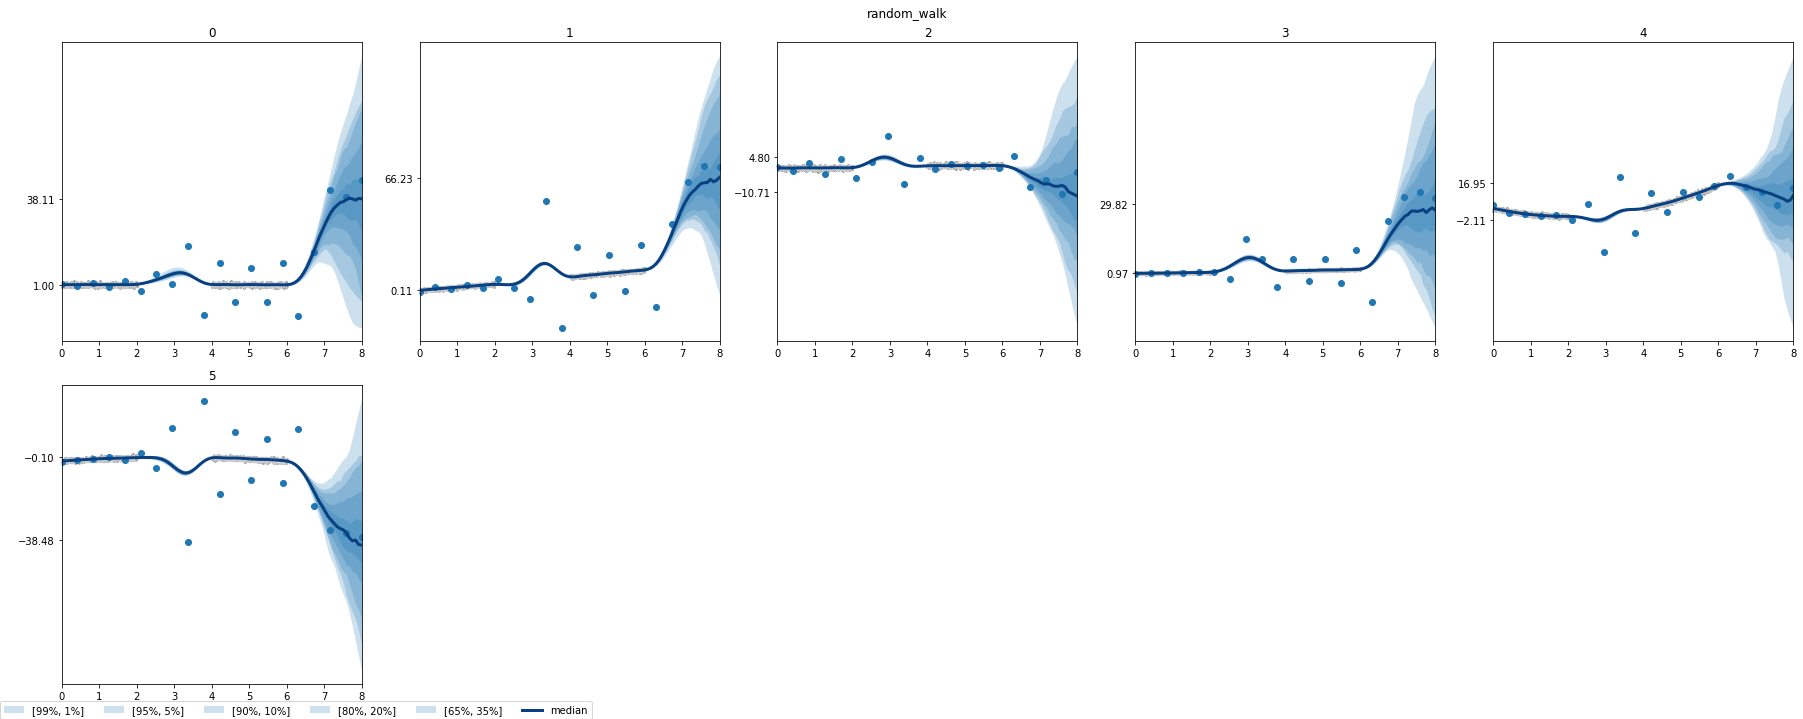

In [33]:
feature_ids = observation_value.columns
for model_id, model in models.items():
    fig = model["causal"].plot_features(feature_ids = feature_ids);
    for feature_id, ax in zip(feature_ids, fig.axes):
        k = model["observed"].samples[model.observation.p.loc.knot].mean("sample")
        a = model["observed"].samples[model.observation.p.loc.a].mean("sample").sel(gene = feature_id)
        ax.scatter(k, a)

#         baseline = model["observed"].samples[model.observation.p.loc.b].mean("sample").sel(gene = feature_id)
#         ax.axhline(
#             baseline,
#             color = "#333333",
#             dashes = [2]
#         )
#         ax.axhline(
#             0,
#             color = "#333333"
#         )
    fig.suptitle(model_id)

Conclusion:
- Splines are useful for interpolation
- Splines are not useful for extrapolation, and we need to be careful when training